In [6]:
from mongo import MongoDBReader

db = MongoDBReader()

In [7]:
user_feedbacks = db.get_bot_recommendation_feedbacks()


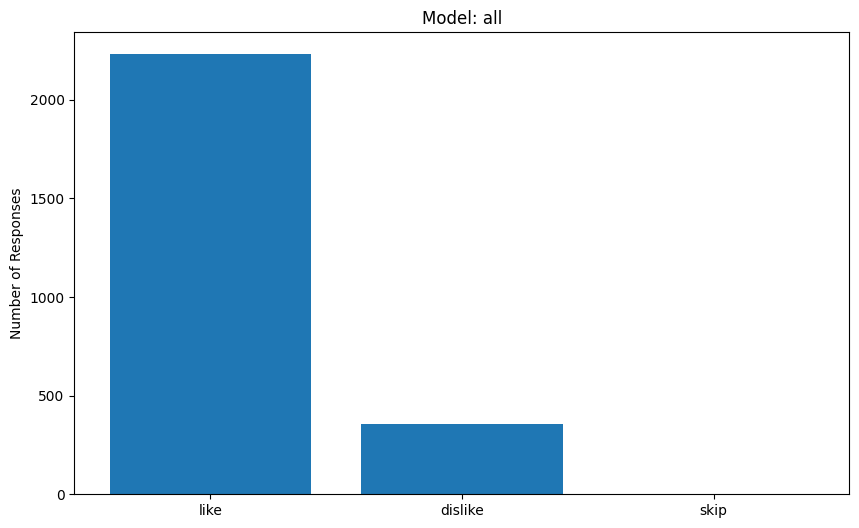

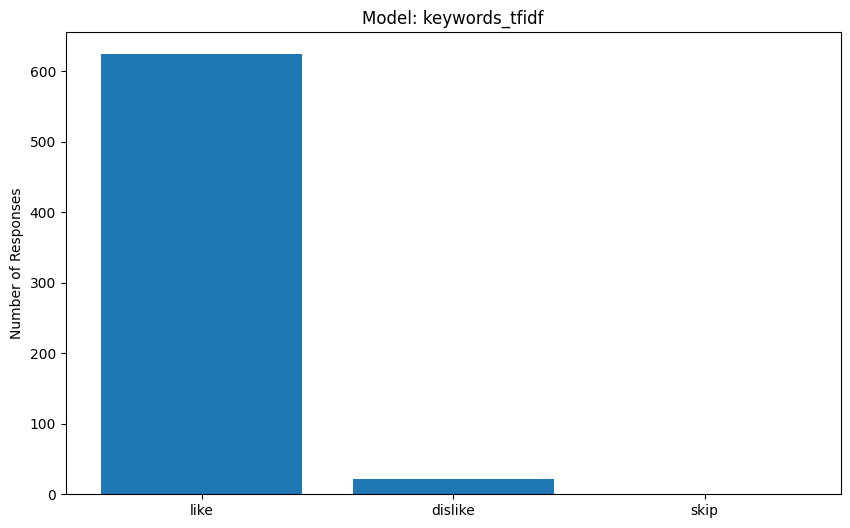

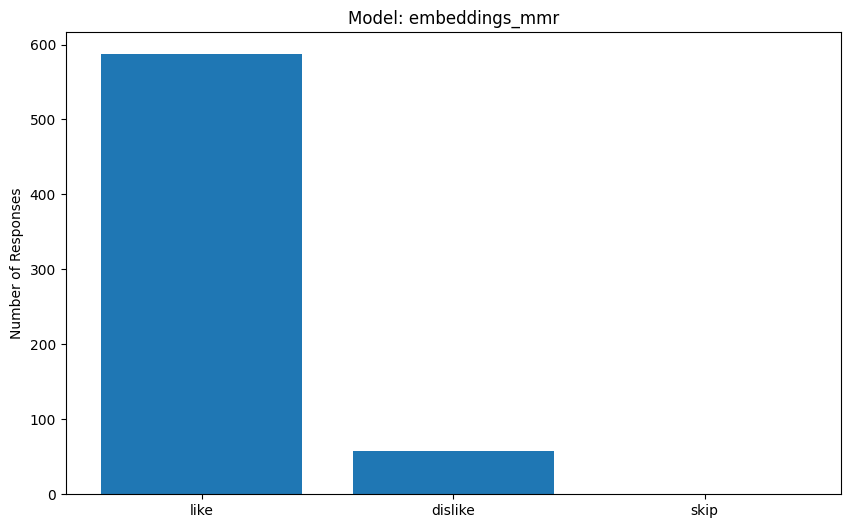

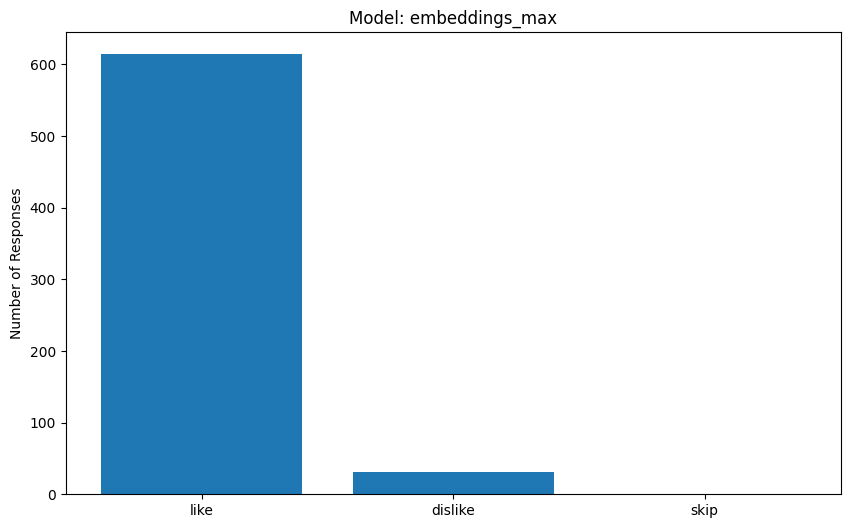

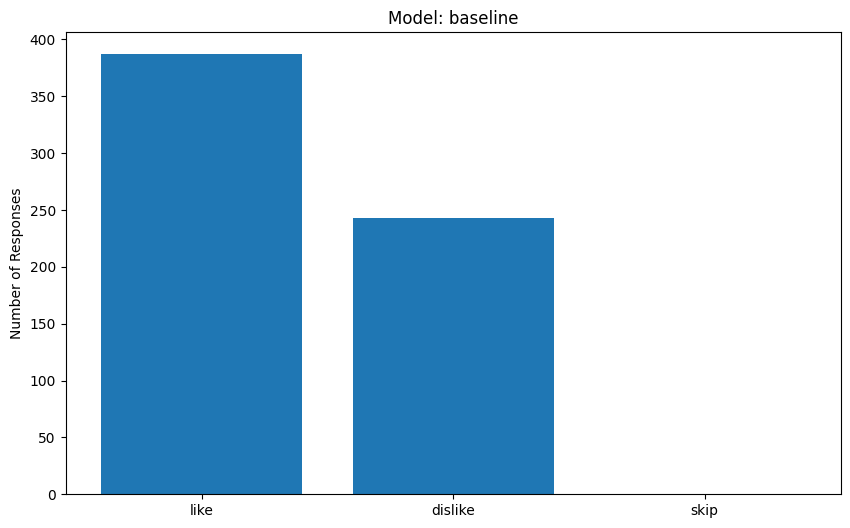

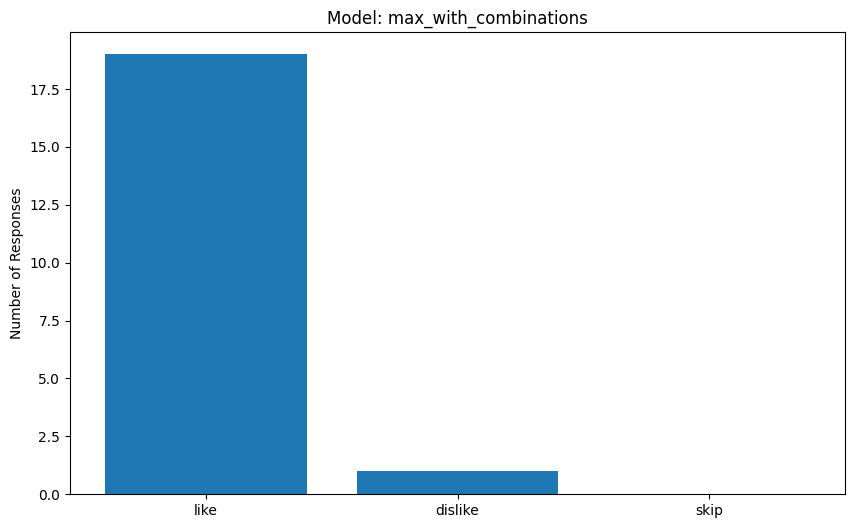

In [8]:
import matplotlib.pyplot as plt

user_feedbacks = db.get_bot_recommendation_feedbacks()

# Count likes and dislikes and skips
models = {}
for feedback in user_feedbacks:
    if feedback['model'] not in models:
        models[feedback['model']] = {"like": 0, "dislike": 0, "skip": 0}
    if feedback['action'] == "like":
        models[feedback['model']]["like"] += 1
    elif feedback['action'] == "dislike":
        models[feedback['model']]["dislike"] += 1
    elif feedback['action'] == "skip":
        models[feedback['model']]["skip"] += 1

all_models = {
    "like": sum([models[model]["like"] for model in models]),
    "dislike": sum([models[model]["dislike"] for model in models]),
    "skip": sum([models[model]["skip"] for model in models])
}

def plot_model_feedback_distribution(like, dislike, skip, model):
    # Create bar plot
    plt.figure(figsize=(10,6))
    plt.bar(['like', 'dislike', 'skip'], [like, dislike, skip])
    plt.title('Model: ' + model)
    plt.ylabel('Number of Responses')
    plt.show()

# now for all models together
plot_model_feedback_distribution(all_models["like"], all_models["dislike"], all_models["skip"], "all")

for model in models:
    plot_model_feedback_distribution(models[model]["like"], models[model]["dislike"], models[model]["skip"], model)



<Figure size 1000x600 with 0 Axes>

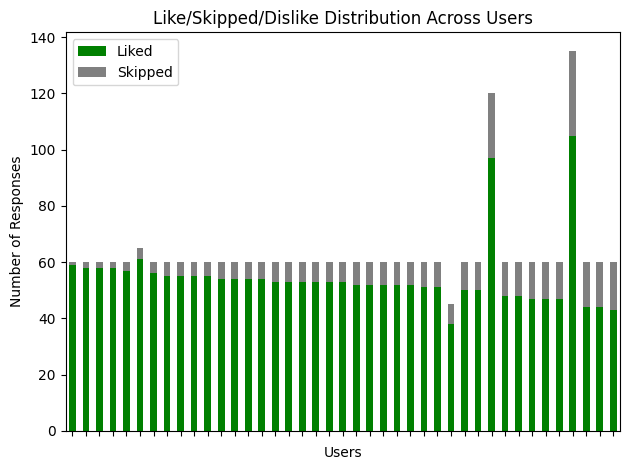

In [9]:
import pandas as pd

user_feedbacks = db.get_bot_recommendation_feedbacks()


# Convert feedback data to DataFrame format
feedback_data = []
for feedback in user_feedbacks:
    feedback_data.append({
        'user_id': feedback['user_id'],
        'action': feedback['action']
    })
df = pd.DataFrame(feedback_data)

# Group by user_id and count actions
user_stats = df.groupby('user_id')['action'].value_counts().unstack(fill_value=0)


def plot_like_dislike_distribution(user_stats, relative=False):
    # Create stacked bar chart
    plt.figure(figsize=(10,6))
    
    if relative:
        # Convert to percentages
        plot_data = user_stats.div(user_stats.sum(axis=1), axis=0) * 100
        ylabel = 'Percentage of Responses'
    else:
        plot_data = user_stats
        ylabel = 'Number of Responses'
    
    # Sort by percentage of likes (descending)
    like_percentages = user_stats["like"] / user_stats.sum(axis=1)
    plot_data = plot_data.iloc[like_percentages.argsort()][::-1]
    
    # sort plot_data like this: like, dislike, skip
    if "skip" in plot_data.columns:
        plot_data = plot_data[['like', 'skip', 'dislike']]
    else:
        plot_data = plot_data[['like', 'dislike']]
    
    plot_data.plot(kind='bar', stacked=True, color=['green', 'grey', 'red'])
    plt.title('Like/Skipped/Dislike Distribution Across Users')
    plt.xlabel('Users')
    plt.ylabel(ylabel)
    plt.legend(['Liked', 'Skipped', 'Disliked'])
    plt.xticks(range(len(user_stats.index)), [''] * len(user_stats.index), rotation=0)
    plt.tight_layout()
    plt.show()

plot_like_dislike_distribution(user_stats)
# plot_like_dislike_distribution(user_stats, relative=True)

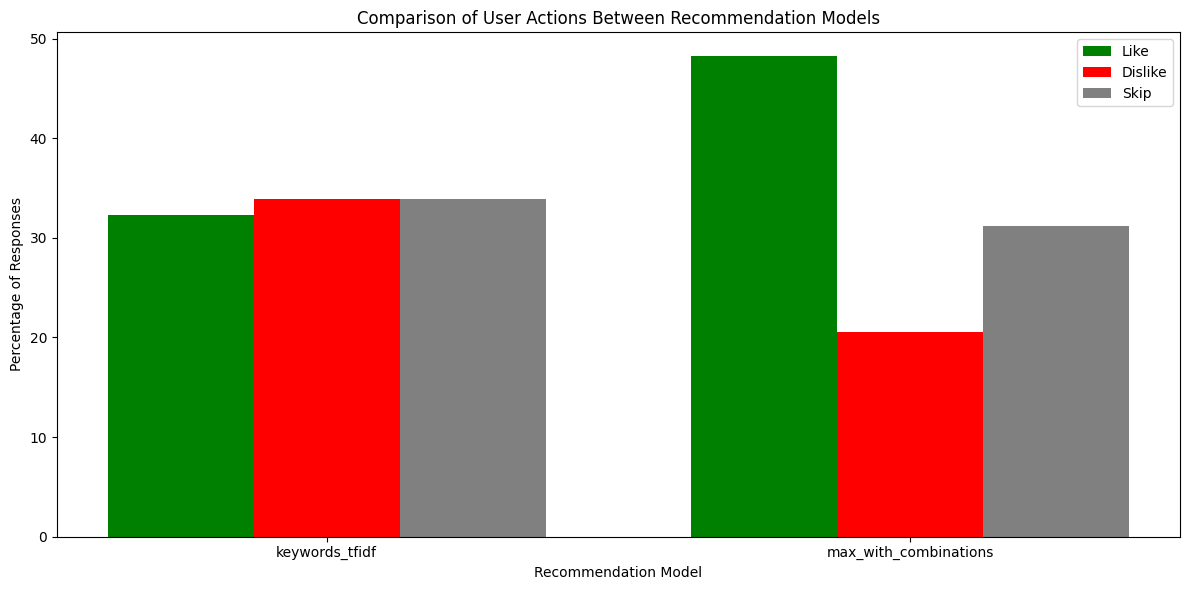


Number of unique users per model:
model
keywords_tfidf            6
max_with_combinations    12
Name: user_id, dtype: int64

Total number of interactions per model:
model
keywords_tfidf           124
max_with_combinations    170
dtype: int64

Average interactions per user for each model:
model
keywords_tfidf           20.67
max_with_combinations    14.17
dtype: float64

Raw numbers of actions per model:
action                 dislike  like  skip
model                                     
keywords_tfidf              42    40    42
max_with_combinations       35    82    53

Percentage distribution of actions per model:
action                 dislike   like   skip
model                                       
keywords_tfidf           33.87  32.26  33.87
max_with_combinations    20.59  48.24  31.18


In [25]:
# Get recommendation feedback data
mongo_reader = MongoDBReader()
rec_feedbacks = list(mongo_reader.get_user_recommendation_feedbacks())

# Convert to DataFrame
rec_data = []
for feedback in rec_feedbacks:
    rec_data.append({
        'user_id': feedback['user_id'],
        'action': feedback['action'],
        'model': feedback['model'],
        'course': feedback['course']
    })
rec_df = pd.DataFrame(rec_data)

# Check if we have model data and if the dataframe is not empty
if not rec_df.empty and 'model' in rec_df.columns:
    # Group by model and action to get counts
    model_stats = rec_df.groupby(['model', 'action']).size().unstack(fill_value=0)
    
    # Calculate percentages for each model
    model_percentages = model_stats.div(model_stats.sum(axis=1), axis=0) * 100
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    # Create grouped bar chart
    x = np.arange(len(model_stats.index))
    width = 0.25
    
    for i, action in enumerate(['like', 'dislike', 'skip']):
        if action in model_percentages.columns:
            color = 'green' if action == 'like' else 'red' if action == 'dislike' else 'grey'
            plt.bar(x + i*width, model_percentages[action], width, 
                   label=action.capitalize(), color=color)
    
    plt.xlabel('Recommendation Model')
    plt.ylabel('Percentage of Responses')
    plt.title('Comparison of User Actions Between Recommendation Models')
    plt.xticks(x + width, model_stats.index)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate unique users per model
    unique_users = rec_df.groupby('model')['user_id'].nunique()
    print("\nNumber of unique users per model:")
    print(unique_users)
    
    # Calculate total interactions per model
    total_interactions = rec_df.groupby('model').size()
    print("\nTotal number of interactions per model:")
    print(total_interactions)
    
    # Calculate average interactions per user for each model
    avg_interactions = total_interactions / unique_users
    print("\nAverage interactions per user for each model:")
    print(avg_interactions.round(2))
    print("\nRaw numbers of actions per model:")
    print(model_stats)
    print("\nPercentage distribution of actions per model:")
    print(model_percentages.round(2))
else:
    print("No recommendation feedback data available or missing model information")
